# Multilevel architecture design - C4 Model

The C4 model is a framework for visualizing the architecture of software systems, created by Simon Brown. It provides a hierarchical set of diagrams that represent different levels of abstraction in a system, making it easier for different stakeholders to understand the architecture. The name "C4" stands for "Context, Container, Component, and Code," which are the four levels of diagrams that make up the model.

## The Four Levels of the C4 Model:
1. Context Diagram:
- Purpose: To provide a high-level overview of the system and its interactions with external entities.
- Audience: All stakeholders, including technical and non-technical people.
- Details: Shows the system under consideration, its users, and other systems it interacts with. It answers the question, "What is the system and who are its users?"

2. Container Diagram:
- Purpose: To show the high-level shape of the software architecture and how responsibilities are distributed across different containers.
- Audience: Technical people, including software architects and developers.
- Details: Depicts the major containers (applications or services) that make up the system, their responsibilities, and how they communicate. Containers can include web applications, databases, microservices, and other types of execution environments.

3. Component Diagram:
- Purpose: To decompose each container into its constituent components and show how they interact.
- Audience: Software architects and developers.
- Details: Illustrates the major logical components within a container, their responsibilities, and the interactions between them. This level focuses on the internal structure of a container.

4. Code (Class) Diagram:
- Purpose: To provide detailed design of individual components, typically using UML class diagrams.
- Audience: Developers.
- Details: Shows the implementation details of a specific component, including classes, methods, and relationships between classes. This level is optional and often used for complex components where additional detail is needed.

## Benefits of the C4 Model
Clarity and Communication: By providing different levels of abstraction, the C4 model helps in communicating the architecture to various stakeholders, from non-technical people to developers.
Scalability: The model scales from high-level overviews to detailed designs, making it suitable for large and complex systems.
Consistency: Using a standardized approach to diagramming ensures consistency and clarity across different parts of the system and different projects.
Focus on Different Aspects: Each level of the C4 model focuses on a different aspect of the system, ensuring that all important details are covered.

## Generating C4 Models with AI

**Setup**

Please rename the dot.env.sample file to .env and fill it with your secrets. Ensure all necessary environment variables are correctly populated to ensure smooth application functionality.

**Utilities**

The following blocks contain utilities for generating and display the diagrams

In [1]:
%pip install python-dotenv openai pydantic instructor plantweb
from IPython.display import clear_output
clear_output()

In [2]:
### The current notebook take inspiration from the following project: https://github.com/intellectronica/llms-beyond-chat 
import os
import io
import PIL.Image as Image
import instructor
from IPython.display import display, JSON, Markdown
from dotenv import load_dotenv
from plantweb.render import render
from typing import List
from pydantic import BaseModel, Field

load_dotenv()

def display_markdown(text):
    display(Markdown(text))

def get_env_var(var_name):
    return os.getenv(var_name)

def show_plantuml(uml_code):
    result = render(uml_code, format="png", server="http://localhost:8080/plantuml")
    f = io.BytesIO(result[0])
    return Image.open(f)

AZURE_OPENAI_ENDPOINT = get_env_var("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_API_KEY = get_env_var("AZURE_OPENAI_API_KEY")
MODEL_NAME = "gpt-4-32k" # get_env_var("MODEL_NAME")

# Using AzureOpenAI
from openai import AzureOpenAI
aoai = AzureOpenAI(
    api_version="2024-05-01-preview",
    azure_endpoint= AZURE_OPENAI_ENDPOINT,
    api_key= AZURE_OPENAI_API_KEY,
)
client = instructor.from_openai(aoai)

def llm(response_model: BaseModel = BaseModel, system: str = None,
        user: str = None, temperature: float = 0.0, max_tokens: int = 1000):
    """
    Helper function for calling the LLM with a Pydantic BaseModel,
    a system prompt and/or a user prompt, with temperature and max_tokens.
    """
    messages = []
    if system:
        messages.append({"role": "system", "content": system})
    if user:
        messages.append({"role": "user", "content": user})
    result = client.chat.completions.create(
        model=MODEL_NAME,
        response_model=response_model,
        messages=messages,
        temperature=temperature,
        max_tokens=max_tokens,
    )
    return result


### Architecture requirements

In [3]:
# Load requirements from txt file

with open("../requirements/tinyurl.txt") as f:
    requirements = f.read()

display_markdown(requirements)

Given a url, design a web API that generates a shorter and unique alias of it

Example
Input(102 characters):

https://leetdesign.com/problems/tiny-url?utm_source=leetdesign&utm_medium=social

Output(28 characters):

https://tinyurl.com/5n6et7uf

The service will create an alias for the original URL with a shorter length. If you click on the shorter URL it should redirect to the longer URL.

Functional Requirements:
- Given a url, generate a shorter and unique alias of it
- When user accesses short link, redirect them to the original url

Nonfunctional Requirements:
- 99.99% Availability
- 150ms latency on redirection
- Links expire at 5 years by default
- Should perform globally
- All urls are public

Assumptions:
- Each url is 500 bytes
- 20% of URLs can be stored in a cache
- Cache TTL 24 hrs

Estimated Usage:
- 100 Reads per Write
- 500,000 urls created every month

### Context Diagram

A context diagram, also known as a level 0 data flow diagram (DFD), is a high-level, graphical representation of a system that depicts the system as a single process and shows the interactions it has with external entities. These external entities could be users, systems, or organizations that interact with the system. The context diagram provides an overview of the system's boundaries and the flow of information between the system and its environment.

In [4]:
class User(BaseModel):
    '''
    A user is a person who interacts with the system
    '''
    name: str = Field(
        description="Name of the user"
    )
    role: str = Field(
        description="Role of the user"
    )

class ExternalSystem(BaseModel):
    '''
    An external system is a system that interacts with the main system
    '''
    name: str = Field(
        description="External system name"
    )
    description: str = Field(
        description="External system description"
    )

class System(BaseModel):
    '''
    The main system is the system that is being focused on
    '''
    name: str = Field(
        description="System name"
    )
    description: str = Field(
        description="System description"
    )

class ContextDiagram(BaseModel):
    '''
    A context diagram is a diagram that shows the system and its interactions with users and external systems
    '''
    description: str = Field(
        description="A description of the context diagram"
    )
    users: List[User] = Field(
        description="List of users that interact with the system"
    )
    external_systems: List[ExternalSystem] = Field(
        description="List of external systems that interact with the system"
    )
    system: System = Field(
        description="The main system"
    )

prompt = "You're a software architect who wants to provide a detailed context diagram for the current architecture"
context = f"Here the requirements: {requirements}"

context_diagram = llm(
    ContextDiagram,
    prompt,
    context,
)

# Display the context diagram object
display(JSON(context_diagram.dict()))

<IPython.core.display.JSON object>

## Context  Diagram

This context diagram represents the architecture of an e-commerce web application, specifically an eshop. The eshop interacts with various users and external systems to provide a comprehensive shopping experience.

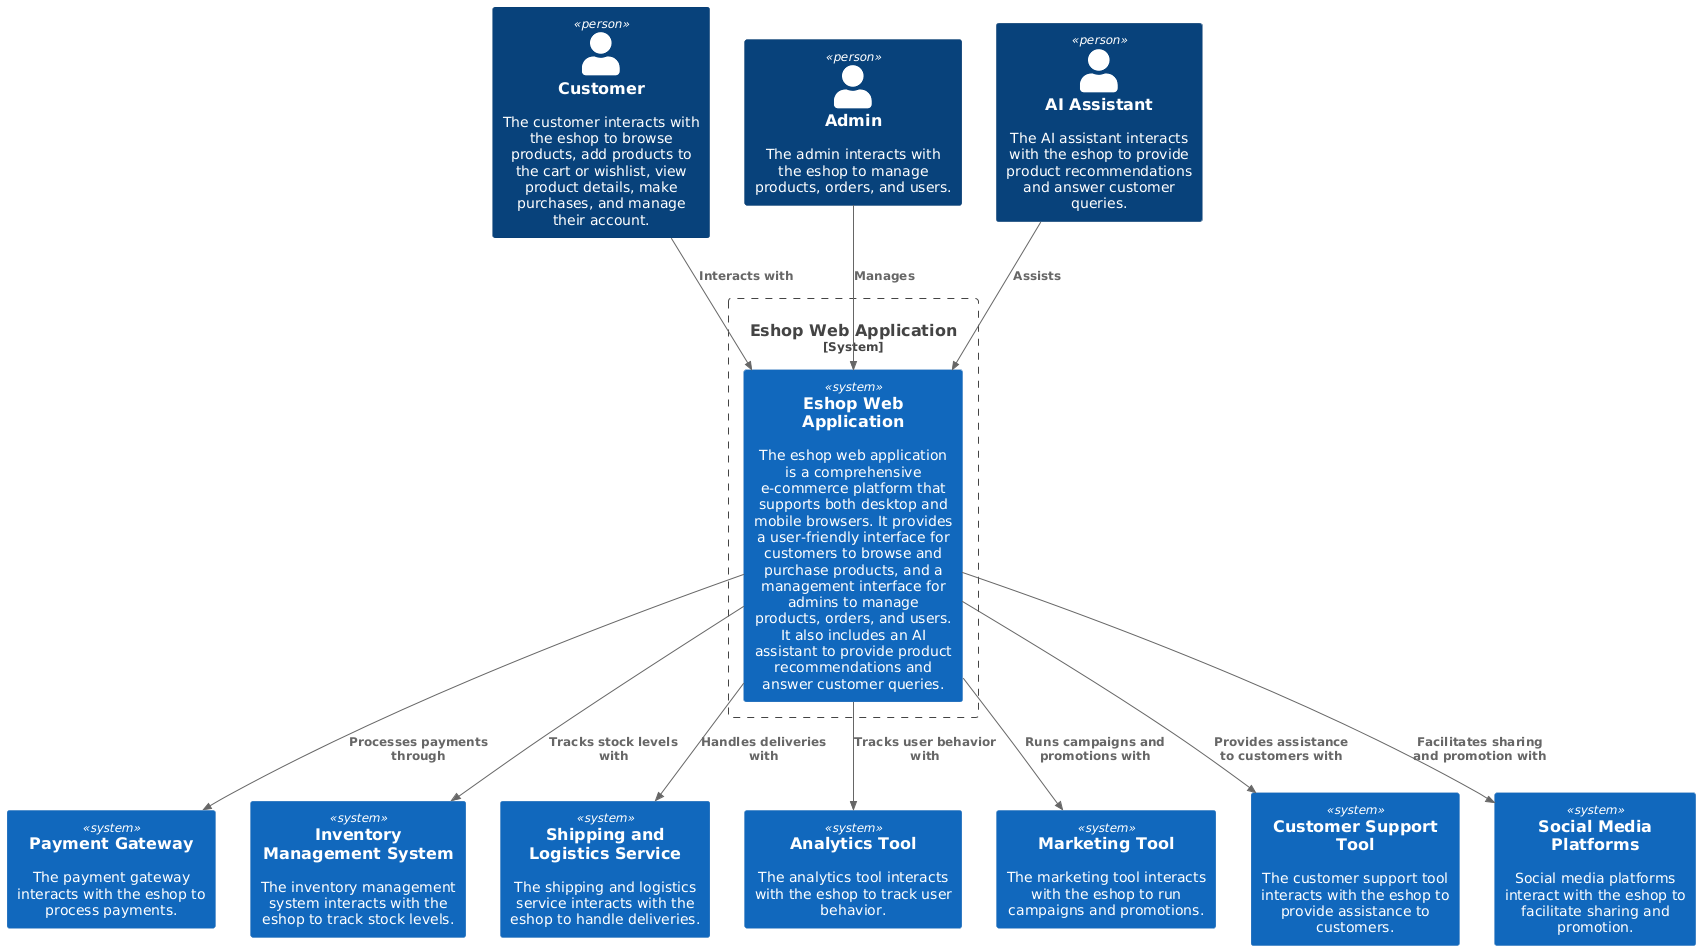

In [12]:
# Convert context diagram object to PlantUML code

class PlantUmlContextDiagram(BaseModel):
    plantuml: str = Field(
        description="PlantUML code for the context diagram using C4-PlantUML. Use the following directive `!include  https://raw.githubusercontent.com/plantuml-stdlib/C4-PlantUML/master/C4_Container.puml`"
    )

plantuml_context_diagram = llm(
    PlantUmlContextDiagram,
    "You're a software architect who wants to provide a C4-PlantUML diagram for the current context diagram json definition",
    f"Here the context diagram definition as json: {context_diagram.model_dump_json()}",
)

display(Markdown("## Context  Diagram"))
display(Markdown(context_diagram.description))
show_plantuml(plantuml_context_diagram.plantuml)


In [13]:
display(Markdown(plantuml_context_diagram.plantuml))

@startuml
!include https://raw.githubusercontent.com/plantuml-stdlib/C4-PlantUML/master/C4_Container.puml

Person(customer, "Customer", "The customer interacts with the eshop to browse products, add products to the cart or wishlist, view product details, make purchases, and manage their account.")
Person(admin, "Admin", "The admin interacts with the eshop to manage products, orders, and users.")
Person(aiAssistant, "AI Assistant", "The AI assistant interacts with the eshop to provide product recommendations and answer customer queries.")

System_Boundary(eshop, "Eshop Web Application") {
  System(eshopSystem, "Eshop Web Application", "The eshop web application is a comprehensive e-commerce platform that supports both desktop and mobile browsers. It provides a user-friendly interface for customers to browse and purchase products, and a management interface for admins to manage products, orders, and users. It also includes an AI assistant to provide product recommendations and answer customer queries.")
}

System(paymentGateway, "Payment Gateway", "The payment gateway interacts with the eshop to process payments.")
System(inventoryManagement, "Inventory Management System", "The inventory management system interacts with the eshop to track stock levels.")
System(shippingService, "Shipping and Logistics Service", "The shipping and logistics service interacts with the eshop to handle deliveries.")
System(analyticsTool, "Analytics Tool", "The analytics tool interacts with the eshop to track user behavior.")
System(marketingTool, "Marketing Tool", "The marketing tool interacts with the eshop to run campaigns and promotions.")
System(customerSupport, "Customer Support Tool", "The customer support tool interacts with the eshop to provide assistance to customers.")
System(socialMedia, "Social Media Platforms", "Social media platforms interact with the eshop to facilitate sharing and promotion.")

Rel(customer, eshopSystem, "Interacts with")
Rel(admin, eshopSystem, "Manages")
Rel(aiAssistant, eshopSystem, "Assists")
Rel(eshopSystem, paymentGateway, "Processes payments through")
Rel(eshopSystem, inventoryManagement, "Tracks stock levels with")
Rel(eshopSystem, shippingService, "Handles deliveries with")
Rel(eshopSystem, analyticsTool, "Tracks user behavior with")
Rel(eshopSystem, marketingTool, "Runs campaigns and promotions with")
Rel(eshopSystem, customerSupport, "Provides assistance to customers with")
Rel(eshopSystem, socialMedia, "Facilitates sharing and promotion with")

@enduml

### Container Diagram

A container diagram is a high-level architectural diagram that visually represents the structure of a software system by illustrating its primary containers and their relationships. It is one of the key diagrams in the C4 model, which is a set of hierarchical diagrams designed to describe software architecture at different levels of detail. The container diagram sits at level 1 in this model, following the context diagram level 0.

In [14]:
# Container diagram

class Container(BaseModel):
    name: str = Field(
        description="Container name"
    )
    description: str = Field(
        description="Container description"
    )
    technology: str = Field(
        description="Container technology"
    )

class ContainerDiagram(BaseModel):
    description: str = Field(
        description="Container Diagram textual description"
    )
    system: System = Field(
        description="The main system"
    )
    containers: List[Container] = Field(
        description="List of containers in the system"
    )
    users: List[User] = Field(
        description="List of users of the system"
    )
    external_systems: List[ExternalSystem] = Field(
        description="List of external systems that interact with the system"
    )

container_diagram_prompt = "You're a software architect who wants to provide a detailed container diagram for the current architecture"
container_diagram_context = f"Here the requirements: {requirements} - Here the context diagram: {context_diagram.model_dump_json()}"

container_diagram = llm(
    ContainerDiagram,
    container_diagram_prompt,
    container_diagram_context,
)

# Display the container diagram object
display(JSON(container_diagram.dict()))


<IPython.core.display.JSON object>

## Container Diagram

This container diagram represents the architecture of an e-commerce web application, specifically an eshop. The eshop is divided into several containers that interact with various users and external systems to provide a comprehensive shopping experience.

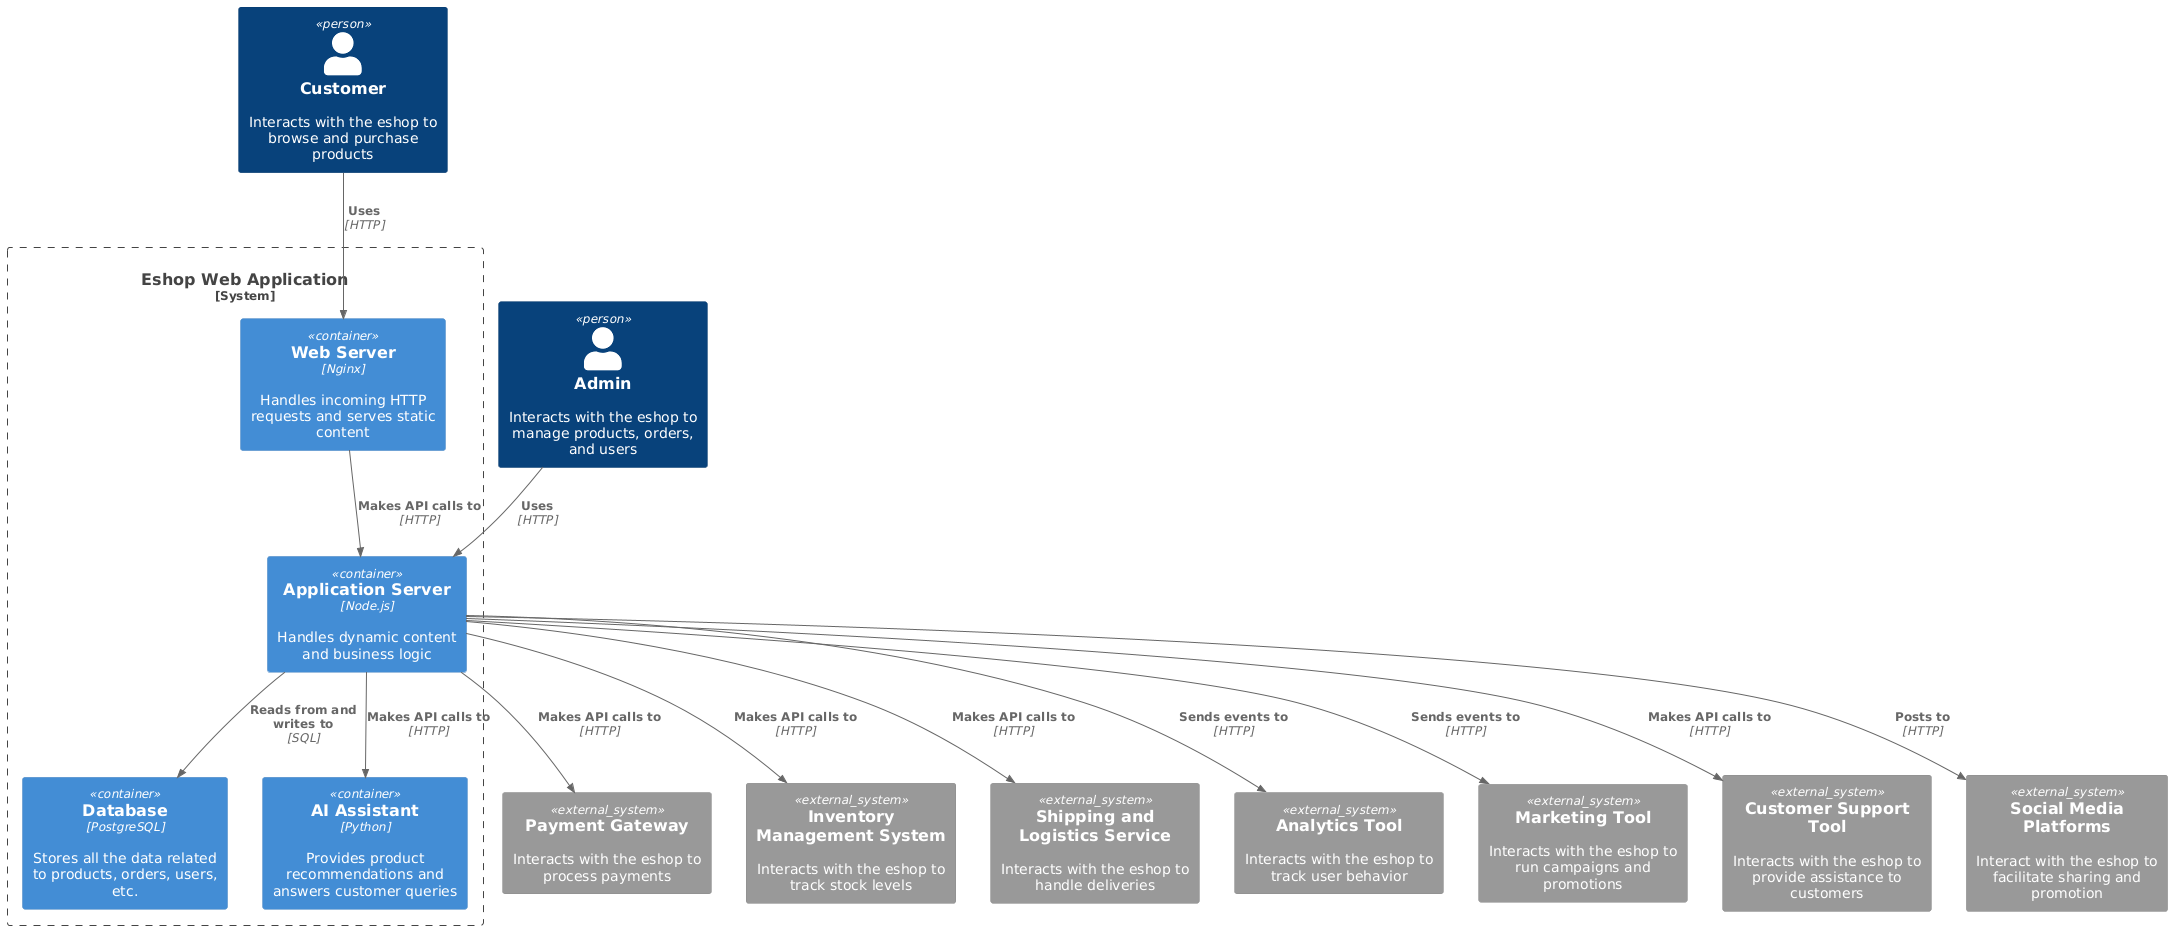

In [15]:
class PlantUmlContainerDiagram(BaseModel):
    plantuml: str = Field(
        description="PlantUML code for the container diagram using C4-PlantUML. Use the folloing directive `!include  https://raw.githubusercontent.com/plantuml-stdlib/C4-PlantUML/master/C4_Container.puml`"
    )

plantuml_container_diagram = llm(
    PlantUmlContainerDiagram,
    "You're a software architect who wants to provide a C4-PlantUML diagram for the current container diagram json definition",
    f"Here the container diagram definition as json: {container_diagram.model_dump_json()}",
)

display(Markdown("## Container Diagram"))
display(Markdown(container_diagram.description))
show_plantuml(plantuml_container_diagram.plantuml)


In [16]:
display(Markdown(plantuml_container_diagram.plantuml))

@startuml
!include https://raw.githubusercontent.com/plantuml-stdlib/C4-PlantUML/master/C4_Container.puml

System_Boundary(eshop, "Eshop Web Application") {
    Container(webServer, "Web Server", "Nginx", "Handles incoming HTTP requests and serves static content")
    Container(appServer, "Application Server", "Node.js", "Handles dynamic content and business logic")
    Container(database, "Database", "PostgreSQL", "Stores all the data related to products, orders, users, etc.")
    Container(aiAssistant, "AI Assistant", "Python", "Provides product recommendations and answers customer queries")
}

Person(customer, "Customer", "Interacts with the eshop to browse and purchase products")
Person(admin, "Admin", "Interacts with the eshop to manage products, orders, and users")
System_Ext(paymentGateway, "Payment Gateway", "Interacts with the eshop to process payments")
System_Ext(inventorySystem, "Inventory Management System", "Interacts with the eshop to track stock levels")
System_Ext(shippingService, "Shipping and Logistics Service", "Interacts with the eshop to handle deliveries")
System_Ext(analyticsTool, "Analytics Tool", "Interacts with the eshop to track user behavior")
System_Ext(marketingTool, "Marketing Tool", "Interacts with the eshop to run campaigns and promotions")
System_Ext(supportTool, "Customer Support Tool", "Interacts with the eshop to provide assistance to customers")
System_Ext(socialMedia, "Social Media Platforms", "Interact with the eshop to facilitate sharing and promotion")

Rel(customer, webServer, "Uses", "HTTP")
Rel(admin, appServer, "Uses", "HTTP")
Rel(webServer, appServer, "Makes API calls to", "HTTP")
Rel(appServer, database, "Reads from and writes to", "SQL")
Rel(appServer, aiAssistant, "Makes API calls to", "HTTP")
Rel(appServer, paymentGateway, "Makes API calls to", "HTTP")
Rel(appServer, inventorySystem, "Makes API calls to", "HTTP")
Rel(appServer, shippingService, "Makes API calls to", "HTTP")
Rel(appServer, analyticsTool, "Sends events to", "HTTP")
Rel(appServer, marketingTool, "Sends events to", "HTTP")
Rel(appServer, supportTool, "Makes API calls to", "HTTP")
Rel(appServer, socialMedia, "Posts to", "HTTP")

@enduml

### Component diagram

A component diagram is a type of diagram used in software engineering to describe the organization and relationships of components within a system. It sits at level 2, offering a more detailed view of the system’s architecture than the container diagram.

In [17]:
# Component diagram

class Component(BaseModel):
    '''
    Component model class, defining the component structure composing a container
    '''
    name: str = Field(
        description="Component name"
    )
    description: str = Field(
        description="Component description"
    )
    technology: str = Field(
        description="Component technology"
    )

class ComponentDiagram(BaseModel):
    description: str = Field(
        description="Component Diagram textual description"
    )
    system: System = Field(
        description="The main system"
    )
    components: List[Component] = Field(
        description="List of components in each container"
    )
    users: List[User] = Field(
        description="List of users of the system"
    )
    external_systems: List[ExternalSystem] = Field(
        description="List of external systems that interact with the system"
    )

component_diagram_prompt = "You're a software architect who wants to provide a detailed component diagram for the current architecture"
component_diagram_context = f"Here the requirements: {requirements} - Here the context diagram: {context_diagram.model_dump_json()} - Here the container diagram: {container_diagram.model_dump_json()}"
                           
component_diagram = llm(
    ComponentDiagram,
    component_diagram_prompt,
    component_diagram_context,
)

# Display the component diagram object
display(JSON(component_diagram.dict()))

<IPython.core.display.JSON object>

## Component Diagram

This component diagram represents the architecture of an e-commerce web application, specifically an eshop. The eshop is divided into several components that interact with various users and external systems to provide a comprehensive shopping experience.

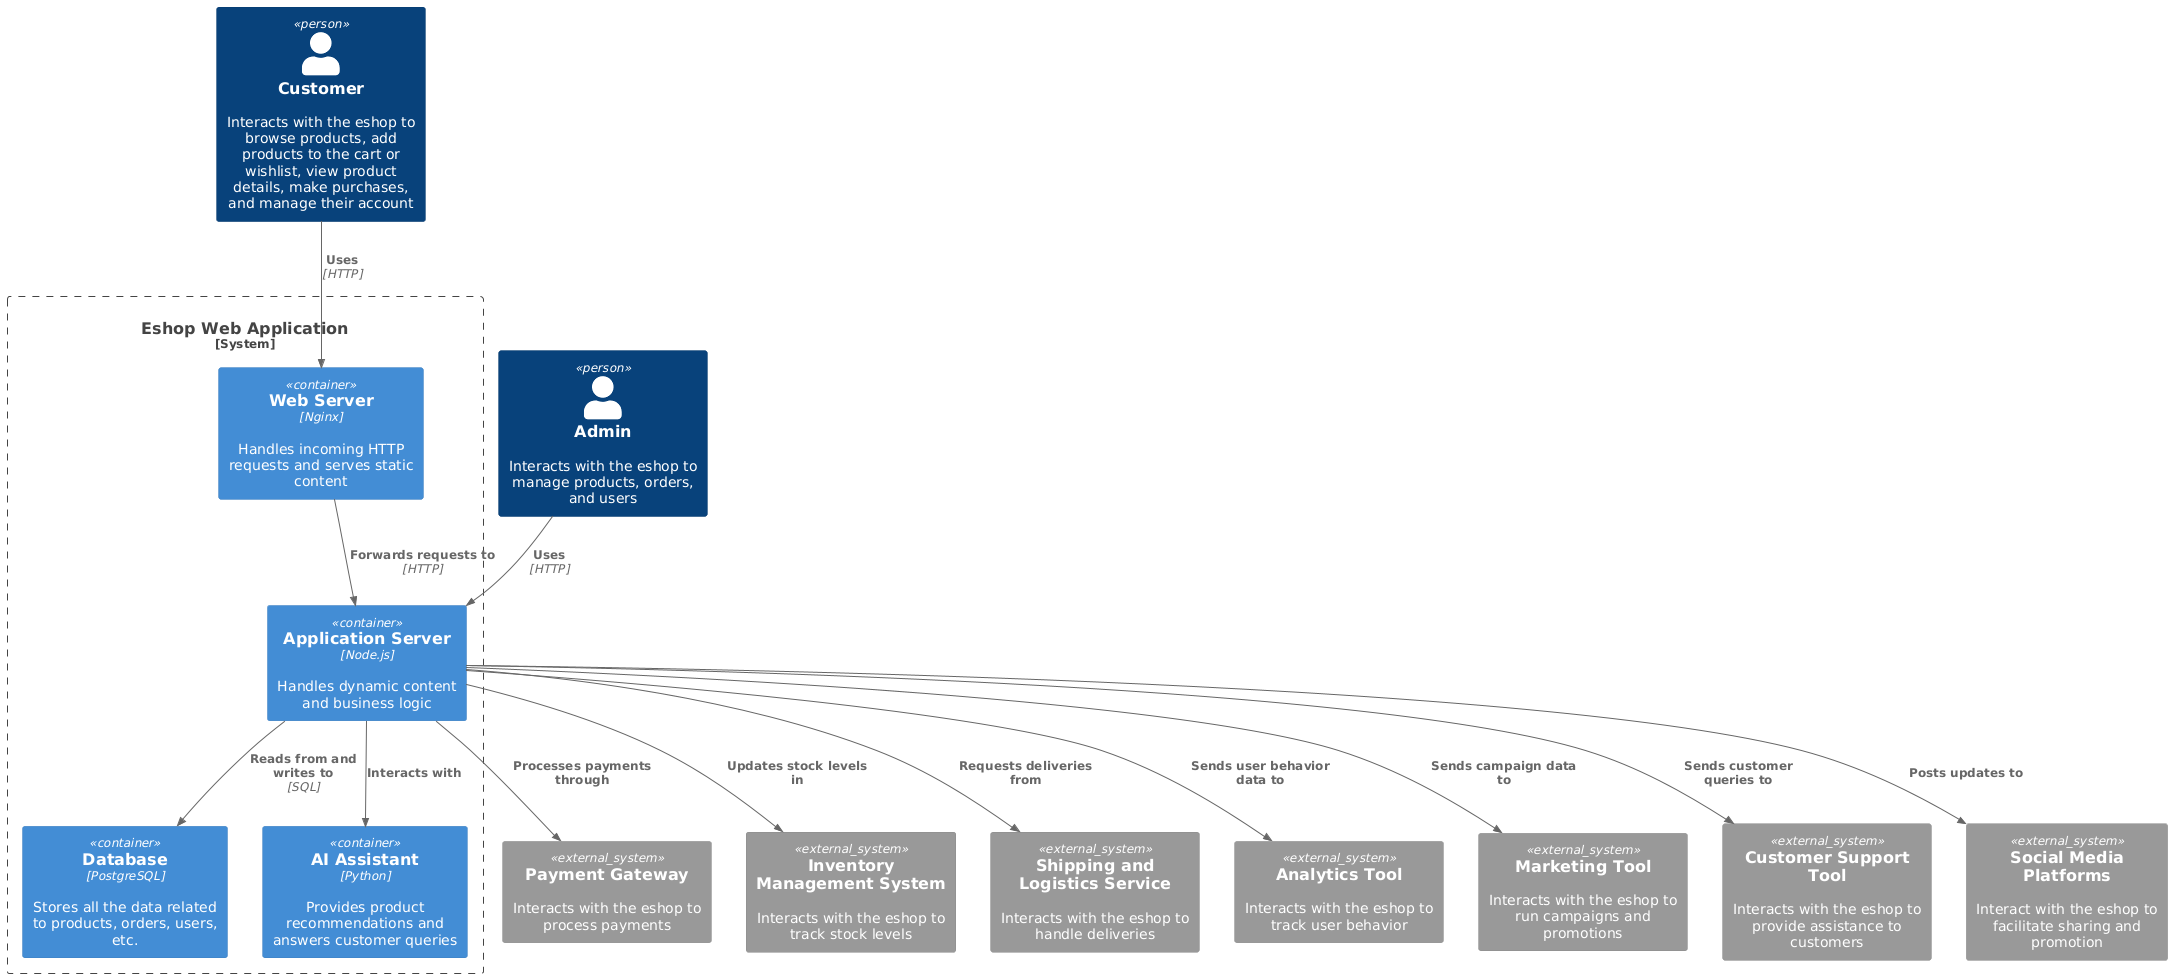

In [18]:
class PlantUmlComponentDiagram(BaseModel):
    plantuml: str = Field(
        description="PlantUML code for the component diagram using C4-PlantUML. Use the folloing directive `!include  https://raw.githubusercontent.com/plantuml-stdlib/C4-PlantUML/master/C4_Container.puml`)"
    )

plantuml_component_diagram = llm(
    PlantUmlComponentDiagram,
    "You're a software architect who wants to provide a C4-PlantUML diagram for the current component diagram json definition",
    f"Here the component diagram definition as json: {component_diagram.model_dump_json()}",
)

display(Markdown("## Component Diagram"))
display(Markdown(component_diagram.description))
show_plantuml(plantuml_component_diagram.plantuml)


### Code Diagram

⚠️ Do not use code diagram ⚠️